# Jena Climate时间序列数据集上使用LSTM进行温度的预报

作者信息：[edencfc](https://github.com/edencfc)

更新日期：2022 年 12 月 8 日

摘要: 本示例将会演示如何使用飞桨完成多维度的时序数据预测任务。**这个任务以温度预报作为示例，将会构建一个CNN+LSTM网络完成任务。**

--

## 1. 简要介绍

本示例将实现在[Jena Climate时间序列数据集](https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip)上基于多变量的历史气象数据，对气温变化的趋势进行预测。


## 2. 环境设置
本示例基于PaddlePaddle 2.4.0 编写，如果你的环境不是本版本，请先参考官网安装 PaddlePaddle 2.4.0。

In [1]:
%matplotlib inline
# 导入 paddle
import paddle
import paddle.nn.functional as F

print(paddle.__version__)

2.4.0


In [2]:
# 导入其他模块
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

## 3. 数据集

我们将使用的Jena Climate数据集来自 [Max Planck Institute for Biogeochemistry](https://www.bgc-jena.mpg.de/wetter/). 该数据集包括温度、压力、湿度等14个特征指标，每10分钟记录一次。

**记录地点**: Weather Station, Max Planck Institute for Biogeochemistry in Jena, Germany

**记录时间**: 2009.01.19 - 2016.12.31

下表包括了数据列名、对应数据值以及他们的描述，主要就是一些气象单位的记录。

| 索引 | 特征 | 数值 | 描述 |
| --- | --- | --- | --- |
| 1 | Date Time | 01.01.2009 00:10:00 | Date-time reference |
| 2 | p (mbar) | 996.52 | The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars. |
| 3 | T (degC) | \-8.02 | Temperature in Celsius |
| 4 | Tpot (K) | 265.4 | Temperature in Kelvin |
| 5 | Tdew (degC) | \-8.9 | Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses. |
| 6 | rh (%) | 93.3 | Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects. |
| 7 | VPmax (mbar) | 3.33 | Saturation vapor pressure |
| 8 | VPact (mbar) | 3.11 | Vapor pressure |
| 9 | VPdef (mbar) | 0.22 | Vapor pressure deficit |
| 10 | sh (g/kg) | 1.94 | Specific humidity |
| 11 | H2OC (mmol/mol) | 3.12 | Water vapor concentration |
| 12 | rho (g/m \*\* 3) | 1307.75 | Airtight |
| 13 | wv (m/s) | 1.03 | Wind speed |
| 14 | max. wv (m/s) | 1.75 | Maximum wind speed |
| 15 | wd (deg) | 152.3 | Wind direction in degrees |

### 3.1 数据下载与查看
我们可以直接下载数据集到本地。

In [4]:
# 命令行执行
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip
# 解压数据集
!unzip jena_climate_2009_2016.csv.zip

加载并查看数据集。

In [3]:
csv_path = "jena_climate_2009_2016.csv"
df = pd.read_csv(csv_path)

In [4]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 3.2 时间序列数据的展示
为了让我们了解正在处理的数据，下面绘制了每个指标从2009年到2016年期间每个特征的时间序列趋势。从中我们可以发现存在异常的事件，可以在后续处理中进行关注。

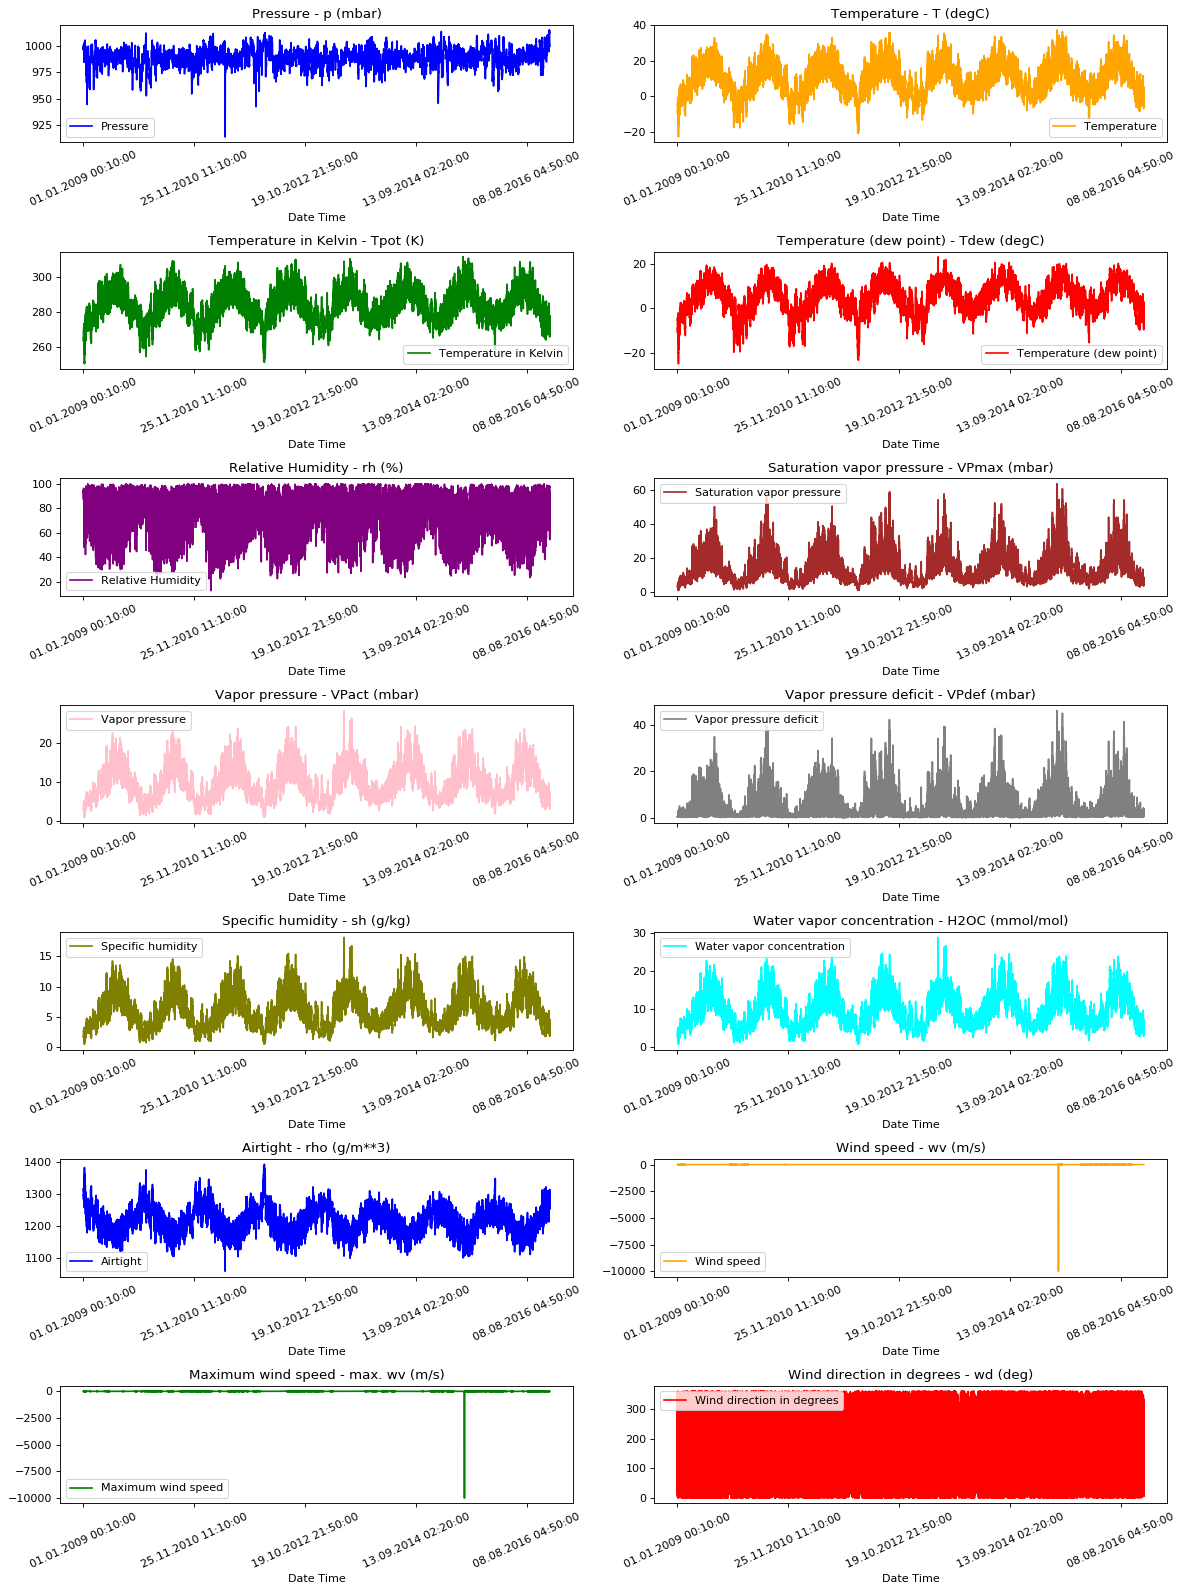

In [4]:
titles = [
    "Pressure",
    "Temperature",
    "Temperature in Kelvin",
    "Temperature (dew point)",
    "Relative Humidity",
    "Saturation vapor pressure",
    "Vapor pressure",
    "Vapor pressure deficit",
    "Specific humidity",
    "Water vapor concentration",
    "Airtight",
    "Wind speed",
    "Maximum wind speed",
    "Wind direction in degrees",
]

feature_keys = [
    "p (mbar)",
    "T (degC)",
    "Tpot (K)",
    "Tdew (degC)",
    "rh (%)",
    "VPmax (mbar)",
    "VPact (mbar)",
    "VPdef (mbar)",
    "sh (g/kg)",
    "H2OC (mmol/mol)",
    "rho (g/m**3)",
    "wv (m/s)",
    "max. wv (m/s)",
    "wd (deg)",
]

colors = [
    "blue",
    "orange",
    "green",
    "red",
    "purple",
    "brown",
    "pink",
    "gray",
    "olive",
    "cyan",
]

date_time_key = "Date Time"


def show_raw_visualization(data):
    time_data = data[date_time_key]
    fig, axes = plt.subplots(
        nrows=7, ncols=2, figsize=(15, 20), dpi=80, facecolor="w", edgecolor="k"
    )
    for i in range(len(feature_keys)):
        key = feature_keys[i]
        c = colors[i % (len(colors))]
        t_data = data[key]
        t_data.index = time_data
        t_data.head()
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            color=c,
            title="{} - {}".format(titles[i], key),
            rot=25,
        )
        ax.legend([titles[i]])
    plt.tight_layout()


show_raw_visualization(df)

### 3.3 相关性热图
分析不同指标之间的相关性情况如下：

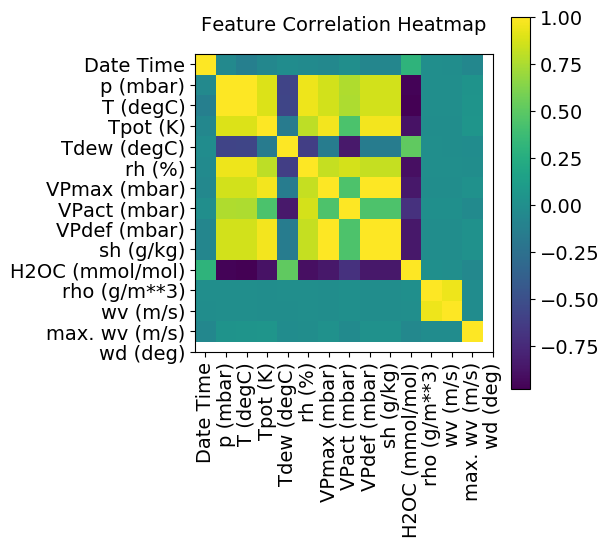

In [6]:
def show_heatmap(data):
    plt.matshow(data.corr())
    plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=90)
    plt.gca().xaxis.tick_bottom()
    plt.yticks(range(data.shape[1]), data.columns, fontsize=14)

    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=14)
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()


show_heatmap(df)

从相关性分析热力图中，我们可以看到部分指标之间有非常强的相关性，因此, 我们可以只选取其中一部分指标（相关性高的只保留1个）。
### 3.4 划分训练集与验证集

In [5]:
split_fraction = 0.715
train_split = int(split_fraction * int(df.shape[0]))
step = 6

past = 720
future = 72


# 数据归一化
def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std

In [6]:
print(
    "选取的指标是:",
    ", ".join([titles[i] for i in [0, 1, 5, 7, 8, 10, 11]]),
)
selected_features = [feature_keys[i] for i in [0, 1, 5, 7, 8, 10, 11]]
features = df[selected_features]
features.index = df[date_time_key]
features.head()

# 原始数据集存在重复项，要进行去重
features.drop_duplicates(keep="first", inplace=True)

features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

选取的指标是: Pressure, Temperature, Saturation vapor pressure, Vapor pressure deficit, Specific humidity, Airtight, Wind speed


构造训练集和验证集：验证集不包含最后792（720 + 72）行，因为准备预留作为测试数据。

In [7]:
start = past + future
end = start + train_split
x_train = train_data[[i for i in range(7)]].values
sequence_length = int(future / step)

In [8]:
print("x_train shape:", x_train.shape)

x_train shape: (300693, 7)


In [9]:
x_end = len(val_data) - past - future
x_val = val_data.iloc[:x_end][[i for i in range(7)]].values
x_test = val_data.iloc[x_end:][[i for i in range(7)]].values

In [10]:
class MyDataset(paddle.io.Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """

    def __init__(self, data, time_steps):
        """
        步骤二：实现 __init__ 函数，初始化数据集，将样本和标签映射到列表中，其中time_steps是滑动时间窗口的长度
        """
        super(MyDataset, self).__init__()
        self.time_steps = time_steps
        self.data = paddle.to_tensor(self.transform(data), dtype="float32")
        self.label = paddle.to_tensor(self.transform_(data), dtype="float32")

    def transform(self, data):
        """
        构造窗口化时序数据，即连续的time_steps长度时序数据，可以包括多个指标
        """
        output = []
        for i in range(len(data) - self.time_steps):
            output.append(data[i : (i + self.time_steps)])
        return np.array(output)

    def transform_(self, data):
        """
        构造时序标签，每一个窗口的数据标签是窗口末端的温度值（第二个指标）
        """
        output_ = []
        for i in range(len(data) - self.time_steps):
            output_.append(data[i + self.time_steps, 1])
        return np.array(output_)

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__函数，定义指定index时如何获取数据，并返回单条数据（样本数据、对应的标签）
        """
        data = self.data[index]
        label = self.label[index]
        return data, label

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return len(self.data)


# 实例化数据集
train_dataset = MyDataset(x_train, future)
eval_dataset = MyDataset(x_val, future)
test_dataset = MyDataset(x_test, future)

## 4. 模型组网
由于有多个指标作为时序数据预测的输入，在使用LSTM层之前，先引入了CNN构造，具体步骤如下：
1. 首先是输入层和Reshape层，用于将输入数据转换为指定的输入形式。
2. 然后通过一个2D Conv层进行卷积操作，滤波器个数为64，padding设置为same用于获取相同大小的feature map，激活函数为relu。
3. 接着通过一个Maxpooling进行下采样，然后接一个Dropout用于防止过拟合。
4. 之后连接LSTM层，从时间步的维度进行时序建模。
5. 最后通过全连接层进行输出滑动时间窗口对应的下一时刻预测值。
6. 模型的损失函数选择为均方误差，优化方法采用adam优化器。

In [11]:
# 输入的指标维度
fea_num = 7


class Encoder(paddle.nn.Layer):
    def __init__(self, window_size, fea_num):
        super().__init__()
        self.window_size = window_size
        self.fea_num = fea_num
        self.conv1 = paddle.nn.Conv2D(
            in_channels=1,
            out_channels=64,
            stride=1,
            kernel_size=3,
            padding="same",
        )
        self.relu1 = paddle.nn.ReLU()
        self.pool = paddle.nn.MaxPool2D(kernel_size=2, stride=1, padding="same")
        self.dropout = paddle.nn.Dropout2D(0.3)

        self.lstm1 = paddle.nn.LSTM(
            input_size=64 * fea_num,
            hidden_size=128,
            num_layers=1,
            time_major=False,
        )
        self.fc = paddle.nn.Linear(in_features=128, out_features=64)
        self.relu2 = paddle.nn.ReLU()
        self.head = paddle.nn.Linear(in_features=64, out_features=1)

    def forward(self, x):
        x = x.reshape([x.shape[0], 1, self.window_size, self.fea_num])
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = x.reshape([x.shape[0], self.window_size, -1])
        x, (h, c) = self.lstm1(x)
        x = x[:, -1, :]  # 最后一个LSTM只要窗口中最后一个特征的输出
        x = self.fc(x)
        x = self.relu2(x)
        x = self.head(x)

        return x

In [12]:
# 打印网络结构
model = Encoder(future, fea_num)
paddle.summary(model, (128, 72, 7))

W1208 01:25:21.663805   170 gpu_resources.cc:61] Please NOTE: device: 0, GPU Compute Capability: 7.0, Driver API Version: 11.2, Runtime API Version: 11.2
W1208 01:25:21.666718   170 gpu_resources.cc:91] device: 0, cuDNN Version: 8.2.


-------------------------------------------------------------------------------------------------------
 Layer (type)       Input Shape                        Output Shape                       Param #    
   Conv2D-1      [[128, 1, 72, 7]]                   [128, 64, 72, 7]                       640      
    ReLU-1       [[128, 64, 72, 7]]                  [128, 64, 72, 7]                        0       
  MaxPool2D-1    [[128, 64, 72, 7]]                  [128, 64, 72, 7]                        0       
  Dropout2D-1    [[128, 64, 72, 7]]                  [128, 64, 72, 7]                        0       
    LSTM-1        [[128, 72, 448]]   [[128, 72, 128], [[1, 128, 128], [1, 128, 128]]]     295,936    
   Linear-1         [[128, 128]]                        [128, 64]                          8,256     
    ReLU-2          [[128, 64]]                         [128, 64]                            0       
   Linear-2         [[128, 64]]                          [128, 1]               

{'total_params': 304897, 'trainable_params': 304897}

## 5. 模型训练
使用模型网络结构和数据集进行模型训练。越复杂的网络结构，模型训练耗时会更长。

在高层API中，可以用 paddle.Model 完成模型封装后，然后通过 Model.prepare 进行训练前的配置准备工作，包括设置优化算法、Loss 计算方法、评价指标计算方法；接着通过Model.fit接口来启动训练。

在训练过程中，需要根据模型训练过程中loss，打印loss下降曲线来调参。为了保存训练时每个batch的loss信息，需要自己定义Callback函数，完成模型训练时loss信息的记录。

In [13]:
# 自定义Callback 需要继承基类 Callback
class LossCallback(paddle.callbacks.Callback):
    def __init__(self):
        self.losses = []

    def on_train_begin(self, logs={}):
        # 在fit前 初始化losses，用于保存每个batch的loss结果
        self.losses = []

    def on_train_batch_end(self, step, logs={}):
        # 每个batch训练完成后调用，把当前loss添加到losses中
        self.losses.append(logs.get("loss"))


loss_log = LossCallback()

In [22]:
from paddle.static import InputSpec

# 参数设置
epoch_num = 30
batch_size = 128
learning_rate = 0.005

inputs = InputSpec([None, 72, 7], "float32", "x")
labels = InputSpec([None, 72, 1], "float32", "x")
model = paddle.Model(Encoder(future, fea_num), inputs, labels)

lr_schedual = paddle.optimizer.lr.CosineAnnealingDecay(
    learning_rate=learning_rate, T_max=epoch_num, verbose=False
)
# 设置优化器，学习率，并且把模型参数给优化器
opt = paddle.optimizer.Adam(
    learning_rate=lr_schedual,
    parameters=model.parameters(),
    beta1=0.9,
    beta2=0.999,
)

model.prepare(opt, paddle.nn.MSELoss(), paddle.metric.Accuracy())

model.fit(
    train_dataset,
    eval_dataset,
    epochs=epoch_num,
    batch_size=batch_size,
    eval_freq=10,
    save_freq=10,
    save_dir="lstm_checkpoint",
    verbose=1,
    drop_last=True,
    shuffle=False,
    callbacks=[loss_log],
)

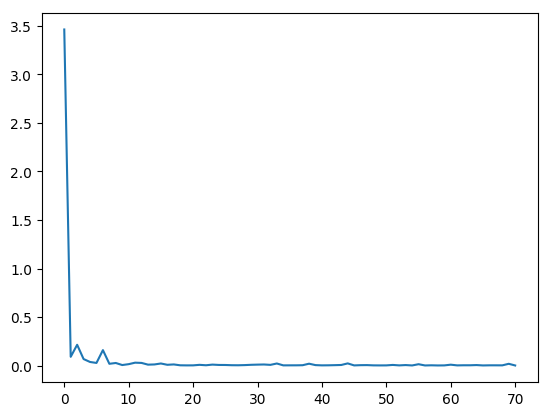

In [15]:
# 可视化 loss
log_loss = [loss_log.losses[i] for i in range(0, len(loss_log.losses), 1000)]
plt.figure()
plt.plot(log_loss)

## 6. 模型评估
评估指标(Metric)用来衡量一个模型的效果, 一般是通过计算模型的预测结果和真实结果之间的某种差距。

使用Paddle高层API的Model.evaluate接口可以一键完成模型评估操作，结束后根据在Model.prepare中定义的loss和metric计算并返回相关评估结果。

In [17]:
model.load("lstm_checkpoint/final")
# 用 evaluate 在测试集上对模型进行验证
eval_result = model.evaluate(eval_dataset, batch_size=batch_size, verbose=1)
print(eval_result)

Eval begin...
step 928/928 [==============================] - loss: 0.0125 - acc: 0.7291 - 7ms/step          
Eval samples: 118664
{'loss': [0.0124636665], 'acc': 0.7290922267916133}


## 7. 模型预测
对模型进行预测，展示效果。高层API中提供了Model.predict接口，可对训练好的模型进行推理验证。只需传入待执行推理验证的样本数据，即可计算并返回推理结果。

In [18]:
model.load("lstm_checkpoint/final")
test_result = model.predict(test_dataset)
# 由于模型是单一输出，test_result的形状为[1, N]，N是测试数据集的数据量。这里打印第一个数据的预测结果。
print(len(test_result))
print(test_result[0][0])

Predict begin...
step 720/720 [==============================] - 2ms/step          
Predict samples: 720
1
[[-0.57714456]]


In [19]:
def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(
                future, plot_data[i], marker[i], markersize=10, label=labels[i]
            )
        else:
            plt.plot(
                time_steps, plot_data[i].flatten(), marker[i], label=labels[i]
            )
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return

选取测试集中的一组序列进行预测：

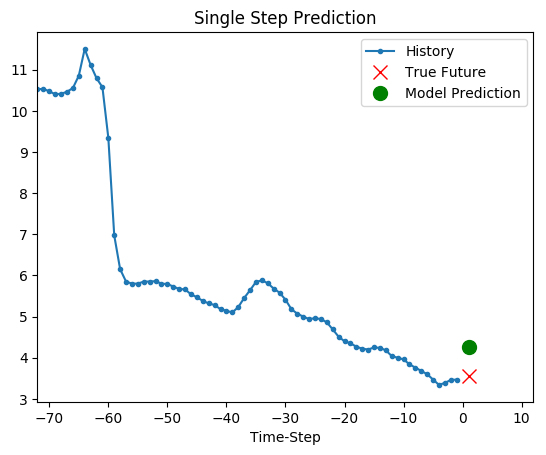

In [20]:
# 滑动窗口的长度是72
# 这里要做一个反归一化处理
mean = df[selected_features][:train_split].mean(axis=0)[1]
std = df[selected_features][:train_split].std(axis=0)[1]

show_plot(
    [
        (x_test[:72, 1] * std + mean),
        (x_test[72, 1] * std + mean),
        (test_result[0][0].flatten()[0] * std + mean),
    ],
    1,
    "Single Step Prediction",
)

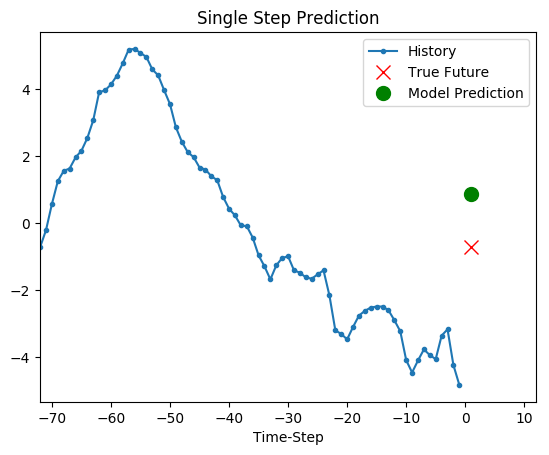

In [21]:
show_plot(
    [
        (x_test[-72:, 1] * std + mean),
        (x_test[-72, 1] * std + mean),
        (test_result[0][-72].flatten()[-1] * std + mean),
    ],
    1,
    "Single Step Prediction",
)